### correlations between point locations and observed SST fields 

In [1]:
%xmode minimal
import warnings

warnings.filterwarnings("ignore")

Exception reporting mode: Minimal


In [2]:
%matplotlib inline

In [3]:
from matplotlib import pyplot as plt

In [4]:
import pathlib

In [5]:
from datetime import datetime

In [6]:
import numpy as np
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

In [7]:
import logging

from climpred import HindcastEnsemble

In [8]:
from dask.diagnostics import ProgressBar

In [9]:
from seasonal_forecasting import C3S, domains, geo, plot, utils, verification

In [10]:
import xskillscore as xs

In [11]:
domain_name = "NZ"
use_verif = "oisst"
GCMs = [
    "ECMWF",
    "UKMO",
    "METEO_FRANCE",
    "DWD",
    "CMCC",
    "NCEP",
    "JMA",
    "ECCC_CanCM4i",
    "ECCC_GEM5_NEMO",
]
varname = "sst"
period = "monthly"  # 'seasonal' or 'monthly'
year_start = 1993
year_end = 2016
obs_to_1deg = False
fig_path = pathlib.Path("../figures/verification/SST")
fig_kwargs = {"dpi": 200, "bbox_inches": "tight", "facecolor": "w"}

In [12]:
domain = domains.domains[domain_name]

In [13]:
from seasonal_forecasting import C3S, domains, geo, plot, utils, verification

In [14]:
def get_valid_lons_lats(dset, lon_name="lon", lat_name="lat"):
    """
    extract the longitude and latitude for LAND grid points
    (i.e. removes the missing values)

    Parameters
    ----------
    dset : xarray dataset
        The xarray dataset with missing values (typically over oceans)
    lon_name : str, default 'lon'
        The name of the variable containing the longitudes
    lat_name : str, default 'lat'
        The name of the variable containing the latitudes

    Returns
    -------
    numpy.ndarray
        numpy array with [lons, lats]
    """

    import numpy as np

    dset1 = dset.isel(time=0)
    dset2 = dset.isel(time=-1)

    def return_lons_lats(ds):
        ds = ds.stack(z=(lon_name, lat_name))
        ds = ds.dropna(dim="z")
        valid_lons = ds[lon_name].data
        valid_lats = ds[lat_name].data
        return np.dstack((valid_lons, valid_lats))[0]

    coords1 = return_lons_lats(dset1)
    coords2 = return_lons_lats(dset2)

    if not (np.allclose(coords1, coords2)):
        raise RuntimeError(
            "There is a problem with the valid coordinates in the dataset, \
                           the coordinates extracted for the first and last time step do not match"
        )
        return None

    else:
        return coords1

In [15]:
def find_nearest(lonslats, point):
    """
    find the nearest point in `lonslats` to `point`

    Parameters
    ----------
    lonlats : numpy.ndarray
        The 2D array containing the [lons, lats] to search
    point : tuple
        A tuple with (lon, lat) of the point

    Returns
    -------
    numpy.ndarray
        [lons, lats] extracted

    """

    from scipy.spatial import cKDTree

    dtree = cKDTree(lonslats)
    dist, ind = dtree.query(point)
    return lonslats[ind]

In [16]:
_, dset_obs = verification.get_OISST(start=year_start, end=year_end, detrend=True)

In [17]:
dset_obs = dset_obs.sel(lon=slice(*domain[:2]), lat=slice(*domain[2:]))

### creates a mask from the observational dataset 

In [18]:
mask_obs = dset_obs.mean(dim="time")

In [19]:
mask_obs = mask_obs.where(np.isnan(mask_obs), 1)

In [20]:
mask_obs = mask_obs.rename({varname: "mask"})["mask"]

### plots the mask 

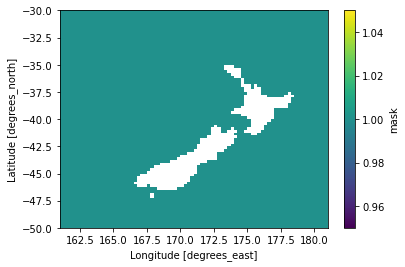

In [21]:
mask_obs.plot()

In [22]:
dset_obs

<xarray.Dataset>
Dimensions:  (time: 288, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
Data variables:
    sst      (time, lat, lon) float64 0.3522 0.358 0.3211 ... -0.04658 -0.11

- Pelorus Sound: 41.1628° S, 173.8632° E  
- Golden Bay: 40.6548° S, 172.8210° E  
- Coromandel: 36.7587° S, 175.4981° E  
- Opotikii: 38.0123° S, 177.2871° E  

In [23]:
valid_lons_lats = get_valid_lons_lats(dset_obs)

In [24]:
valid_lons_lats

array([[161.125, -49.875],
       [161.125, -49.625],
       [161.125, -49.375],
       ...,
       [180.875, -30.625],
       [180.875, -30.375],
       [180.875, -30.125]], dtype=float32)

In [25]:
point_locations = {}
point_locations["Pelorus Sound"] = [-41.1628, 173.8632]
point_locations["Golden Bay"] = [-40.6548, 172.8210]
point_locations["Coromandel"] = [-36.7587, 175.4981]
point_locations["Opotiki"] = [-38.0123, 177.2871]

In [26]:
point_locations = pd.DataFrame(point_locations)

In [27]:
point_locations.index = ["lat", "lon"]

In [28]:
point_locations = point_locations.T

In [29]:
point_locations

,lat,lon
Pelorus Sound,-41.1628,173.8632
Golden Bay,-40.6548,172.8210
Coromandel,-36.7587,175.4981
Opotiki,-38.0123,177.2871


In [30]:
monthly_time_series_point_locations = []

extracted_lons = []
extracted_lats = []

for i, row in point_locations.iterrows():
    location = row.name
    lat = row.lat
    lon = row.lon

    lon_to_extract, lat_to_extract = find_nearest(valid_lons_lats, (lon, lat))

    extracted_lons.append(lon_to_extract)
    extracted_lats.append(lat_to_extract)

    sub = dset_obs.sel(lat=lat_to_extract, lon=lon_to_extract, method="nearest")

    sub = sub[varname].to_series()

    sub = sub.to_frame(name=location)

    monthly_time_series_point_locations.append(sub)

In [31]:
monthly_time_series_point_locations = pd.concat(
    monthly_time_series_point_locations, axis=1
)

In [32]:
point_locations.loc[:, "extracted_lon"] = extracted_lons

In [33]:
point_locations.loc[:, "extracted_lat"] = extracted_lats

In [34]:
point_locations

,lat,lon,extracted_lon,extracted_lat
Pelorus Sound,-41.1628,173.8632,174.125,-41.375
Golden Bay,-40.6548,172.8210,172.875,-40.625
Coromandel,-36.7587,175.4981,175.375,-36.875
Opotiki,-38.0123,177.2871,177.375,-37.875


<AxesSubplot:xlabel='time'>

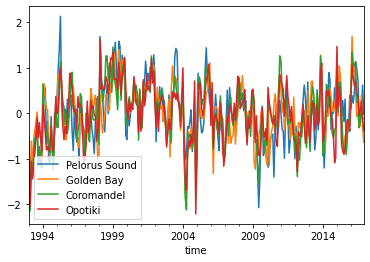

In [35]:
monthly_time_series_point_locations.plot()

In [36]:
monthly_time_series_point_locations.corr()

,Pelorus Sound,Golden Bay,Coromandel,Opotiki
Pelorus Sound,1.000000,0.692497,0.719866,0.672815
Golden Bay,0.692497,1.000000,0.779428,0.745338
Coromandel,0.719866,0.779428,1.000000,0.898124
Opotiki,0.672815,0.745338,0.898124,1.000000


In [37]:
monthly_time_series_point_locations = monthly_time_series_point_locations.to_xarray()

In [38]:
locations_R = []
for v in monthly_time_series_point_locations.data_vars.keys():
    R = xr.corr(monthly_time_series_point_locations[v], dset_obs["sst"], dim="time")
    R = R.expand_dims({"location": [v]})
    locations_R.append(R)

In [39]:
locations_R = xr.concat(locations_R, dim="location")

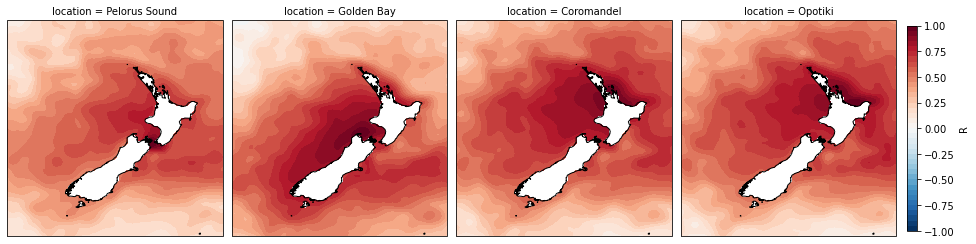

In [40]:
fg = locations_R.plot.contourf(
    levels=np.arange(-1, 1.01, 0.05),
    col="location",
    subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
    transform=ccrs.PlateCarree(),
    figsize=(15, 6),
    cbar_kwargs={"shrink": 0.5, "pad": 0.01, "label": "R"},
)

for ax in fg.axs.flat:
    ax.coastlines(resolution="10m")

fg.fig.savefig(
    fig_path.joinpath(r"R_point_locations_timeseries_observations.png"), **fig_kwargs
)
fg.fig.savefig(
    fig_path.joinpath(r"R_point_locations_timeseries_observations.pdf"), **fig_kwargs
)

In [41]:
from calendar import month_abbr

In [42]:
Rm_locations = []

for v in monthly_time_series_point_locations.data_vars.keys():
    Rm = []

    for m in np.arange(12) + 1:
        R = xr.corr(
            monthly_time_series_point_locations.sel(
                time=(monthly_time_series_point_locations.time.dt.month == m)
            )[v],
            dset_obs.sel(time=(dset_obs.time.dt.month == m))["sst"],
            dim="time",
        )

        R = R.expand_dims({"month": [month_abbr[m]]})

        Rm.append(R)

    Rm = xr.concat(Rm, dim="month")

    Rm = Rm.expand_dims({"location": [v]})

    # Rm = Rm.to_dataset(name=v)

    Rm_locations.append(Rm)

In [43]:
Rm_locations = xr.concat(Rm_locations, dim="location")

In [44]:
for location in point_locations.index:
    print(location)

Pelorus Sound
Golden Bay
Coromandel
Opotiki


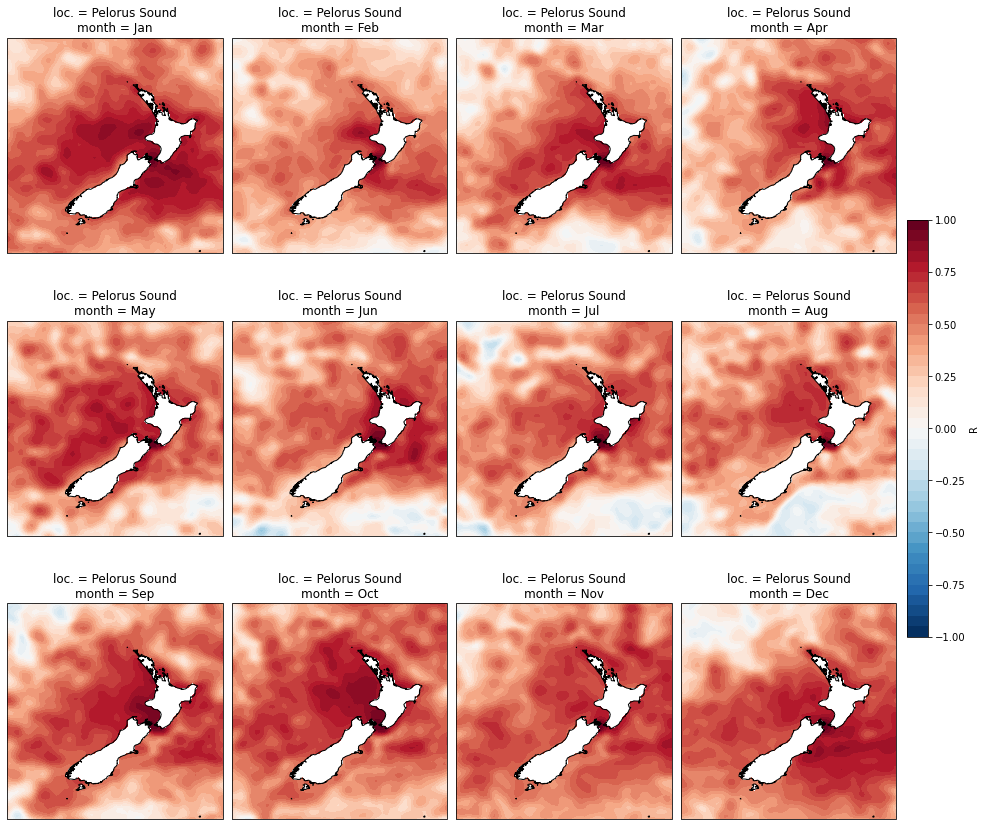

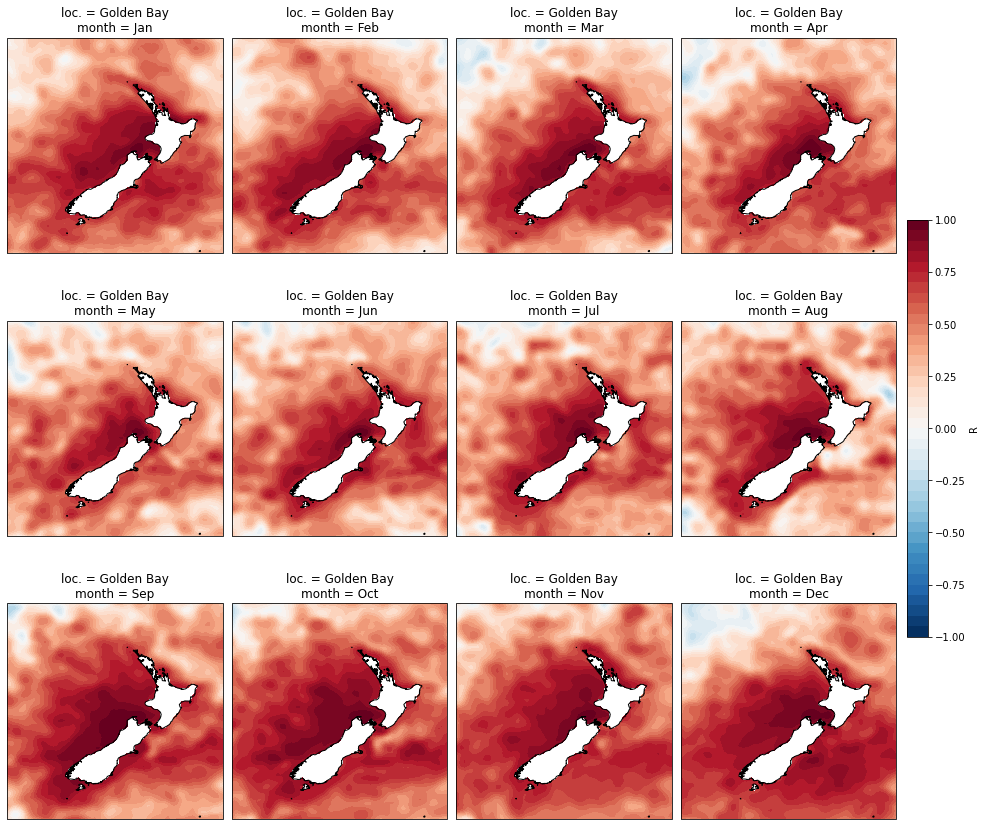

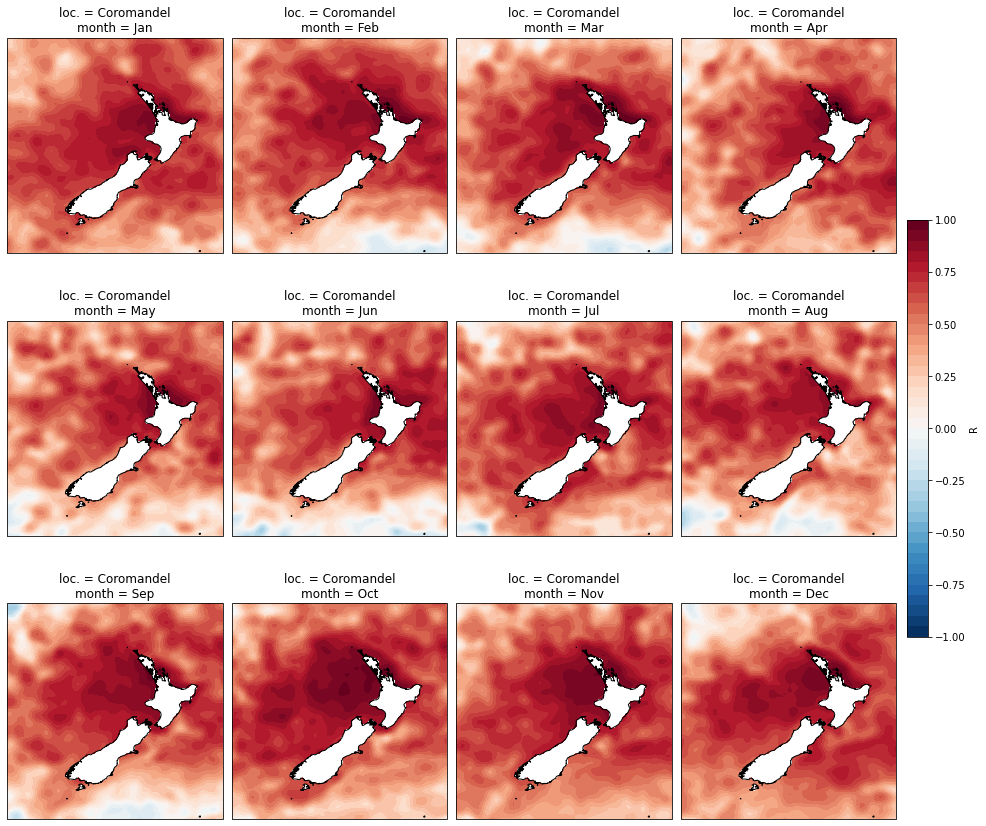

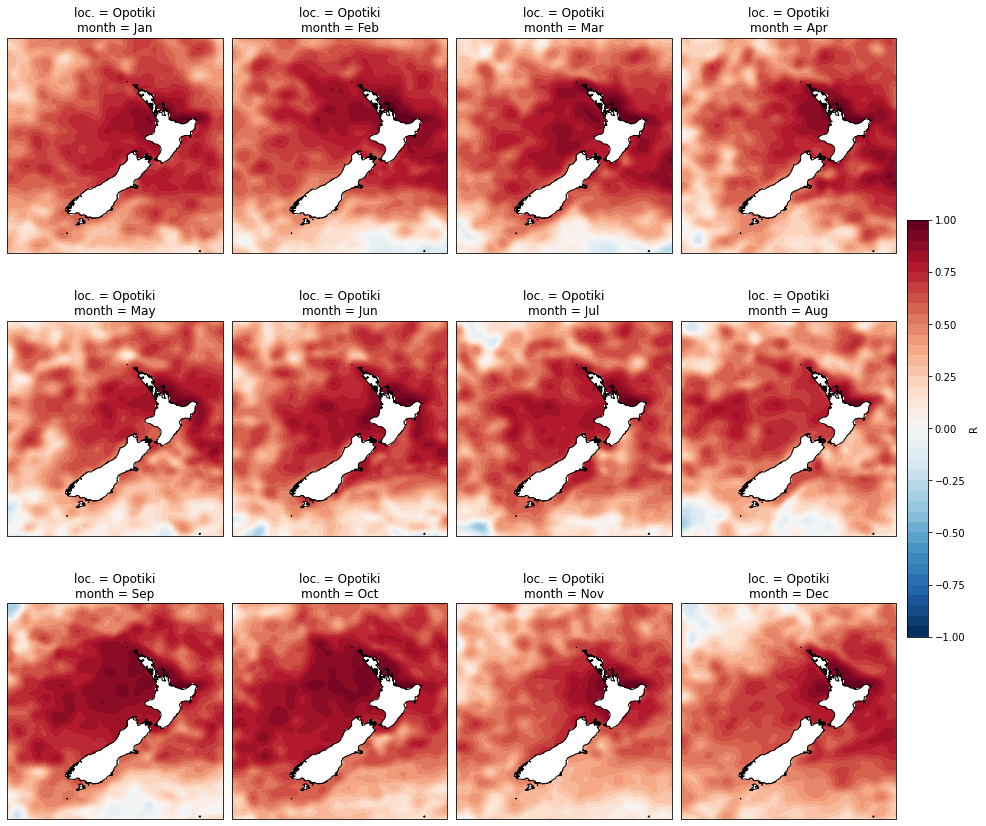

In [45]:
for location in point_locations.index:
    fg = Rm_locations.sel(location=location).plot.contourf(
        levels=np.arange(-1, 1.01, 0.05),
        col="month",
        col_wrap=4,
        subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
        transform=ccrs.PlateCarree(),
        figsize=(15, 12),
        cbar_kwargs={"shrink": 0.5, "pad": 0.01, "label": "R"},
    )

    for ax in fg.axs.flat:
        t = ax.get_title()
        t = f"loc. = {location}\n{t}"
        ax.set_title(t)
        ax.coastlines(resolution="10m")

    fg.fig.savefig(
        fig_path.joinpath(f"R_maps_point_location_obs_{location}_per_month.png"),
        **fig_kwargs,
    )
    fg.fig.savefig(
        fig_path.joinpath(f"R_maps_point_location_obs_{location}_per_month.pdf"),
        **fig_kwargs,
    )

### reads the forecasts

In [46]:
dpath = "/media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/"

In [47]:
MME = C3S.get_GCMs(dpath=dpath, GCM=GCMs, varname=varname, domain=domain, detrend=True)

---------------------------------------------------
reading ECMWF

getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/ECMWF/SST
reading 288 files

first: /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/ECMWF/SST/ensemble_seas_forecasts_sst_from_1993_01_ECMWF.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/ECMWF/SST/ensemble_seas_forecasts_sst_from_2016_12_ECMWF.netcdf
---------------------------------------------------
reading UKMO

getting GCM data from /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/UKMO/SST
reading 287 files

first: /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/UKMO/SST/ensemble_seas_forecasts_sst_from_1993_02_UKMO.netcdf
last: /media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/UKMO/SST/ensemble_seas_forecasts_sst_from_2016_12_UKMO.netcdf
---------------------------------------------------
reading METEO_FRANCE

getting GCM data from /media/nicolasf/END19101/ICU/dat

### drop the problematic initialisation times from the dataset 

In [48]:
drop_inits = [
    datetime(1997, 8, 1),
    datetime(1993, 1, 1),
]  # initial times to drop because of issues in NCEP and UKMO respectively

In [49]:
for drop_date in drop_inits:
    MME = MME.drop_sel(time=drop_date)

In [50]:
MME

<xarray.Dataset>
Dimensions:  (time: 286, lon: 21, lat: 21, step: 5, GCM: 9)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * lon      (lon) float32 161.0 162.0 163.0 164.0 ... 178.0 179.0 180.0 181.0
  * lat      (lat) float32 -50.0 -49.0 -48.0 -47.0 ... -33.0 -32.0 -31.0 -30.0
  * step     (step) int64 1 2 3 4 5
  * GCM      (GCM) object 'ECMWF' 'UKMO' ... 'ECCC_CanCM4i' 'ECCC_GEM5_NEMO'
    month    (GCM, time) float64 2.0 3.0 4.0 5.0 6.0 ... 8.0 9.0 10.0 11.0 12.0
Data variables:
    sst      (GCM, time, step, lat, lon) float64 dask.array<chunksize=(1, 1, 2, 21, 21), meta=np.ndarray>

### calculates seasonal averages if 'seasonal'

In [51]:
if period == "seasonal":
    MME = MME.rolling({"step": 3}, min_periods=3).mean("step")
    MME = MME.sel(step=slice(3, None))

In [52]:
MME

<xarray.Dataset>
Dimensions:  (time: 286, lon: 21, lat: 21, step: 5, GCM: 9)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * lon      (lon) float32 161.0 162.0 163.0 164.0 ... 178.0 179.0 180.0 181.0
  * lat      (lat) float32 -50.0 -49.0 -48.0 -47.0 ... -33.0 -32.0 -31.0 -30.0
  * step     (step) int64 1 2 3 4 5
  * GCM      (GCM) object 'ECMWF' 'UKMO' ... 'ECCC_CanCM4i' 'ECCC_GEM5_NEMO'
    month    (GCM, time) float64 2.0 3.0 4.0 5.0 6.0 ... 8.0 9.0 10.0 11.0 12.0
Data variables:
    sst      (GCM, time, step, lat, lon) float64 dask.array<chunksize=(1, 1, 2, 21, 21), meta=np.ndarray>

### transpose to have GCM and time as the first 2 dimensions 

In [53]:
MME = MME.transpose("GCM", "time", "step", "lat", "lon")

## interpolate the NaNs (takes a while, eats memory ... )

In [54]:
with ProgressBar():
    sst_interp = utils.interpolate_NaN_da(MME[varname].load())

[########################################] | 100% Completed | 28.09 s


In [55]:
MME[varname] = sst_interp

### plot the resulting interpolated SST anomalies 

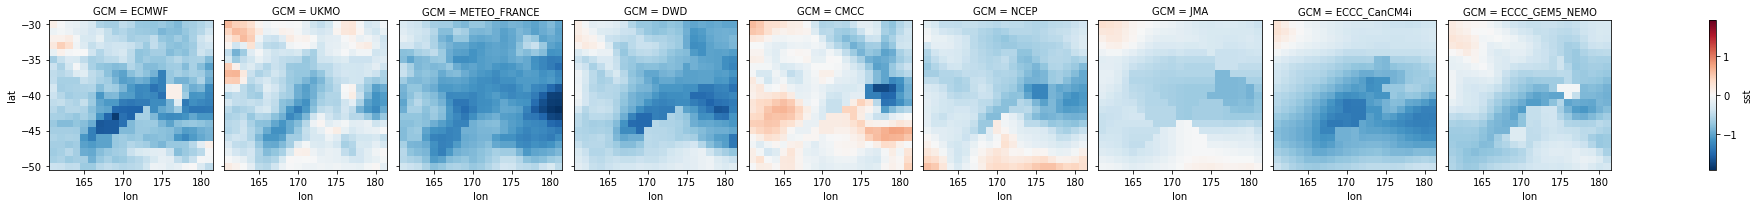

In [56]:
MME.isel(time=0, step=0)[varname].plot(col="GCM")

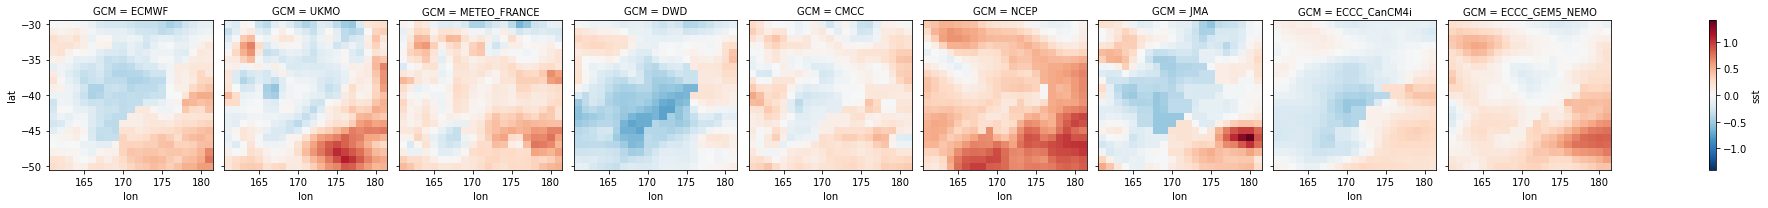

In [57]:
MME.isel(time=-1, step=0)[varname].plot(col="GCM")

### Now, if `obs_to_1deg` is set to False, it means that the MME needs to be interpolated onto the obs dataset grid 

In [58]:
if not (obs_to_1deg):
    MME = MME.interp_like(dset_obs[["lon", "lat"]])

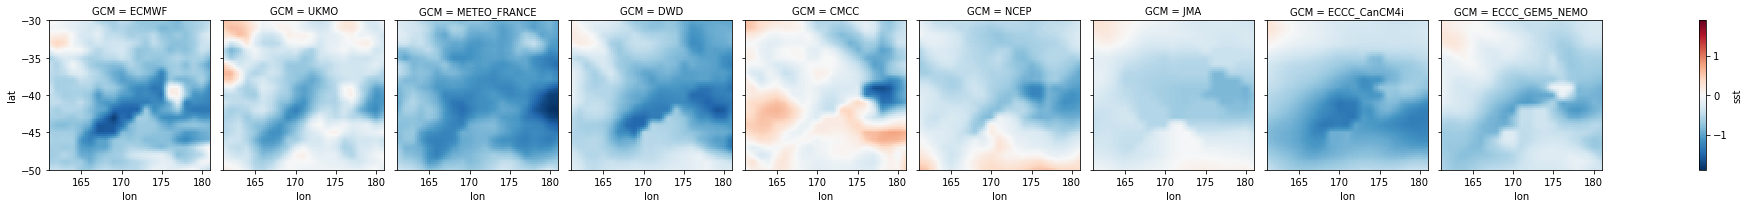

In [59]:
MME.isel(time=0, step=0)[varname].plot(col="GCM")

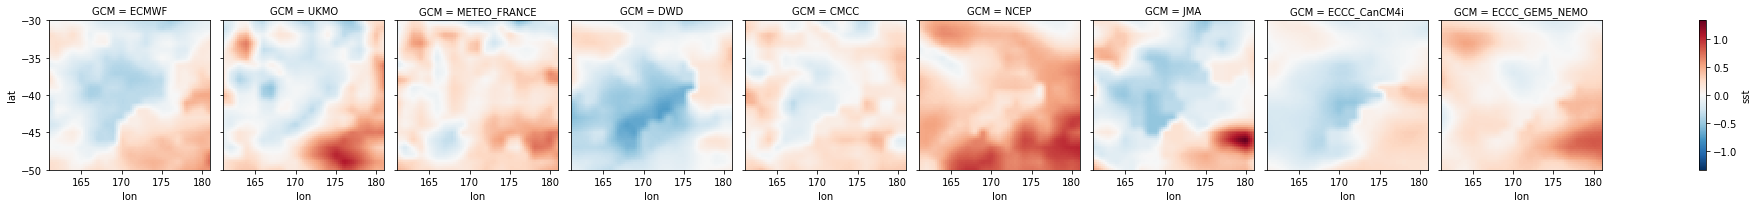

In [60]:
MME.isel(time=-1, step=0)[varname].plot(col="GCM")

### re-chunk, each chunk will take ~ 7 Mb in memory

In [61]:
MME = MME.chunk({"GCM": -1, "time": -1, "step": -1, "lon": -1, "lat": -1})

In [62]:
MME

<xarray.Dataset>
Dimensions:  (time: 286, step: 5, GCM: 9, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * step     (step) int64 1 2 3 4 5
  * GCM      (GCM) object 'ECMWF' 'UKMO' ... 'ECCC_CanCM4i' 'ECCC_GEM5_NEMO'
    month    (GCM, time) float64 dask.array<chunksize=(9, 286), meta=np.ndarray>
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
Data variables:
    sst      (GCM, time, step, lat, lon) float64 dask.array<chunksize=(9, 286, 5, 80, 80), meta=np.ndarray>

### add the ensemble mean to the set of GCMs

In [63]:
MME_mean = MME.mean("GCM")

In [64]:
MME_mean

<xarray.Dataset>
Dimensions:  (time: 286, step: 5, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * step     (step) int64 1 2 3 4 5
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
Data variables:
    sst      (time, step, lat, lon) float64 dask.array<chunksize=(286, 5, 80, 80), meta=np.ndarray>

In [65]:
MME_mean = MME_mean.expand_dims({"GCM": ["MME"]})

In [66]:
MME

<xarray.Dataset>
Dimensions:  (time: 286, step: 5, GCM: 9, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * step     (step) int64 1 2 3 4 5
  * GCM      (GCM) object 'ECMWF' 'UKMO' ... 'ECCC_CanCM4i' 'ECCC_GEM5_NEMO'
    month    (GCM, time) float64 dask.array<chunksize=(9, 286), meta=np.ndarray>
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
Data variables:
    sst      (GCM, time, step, lat, lon) float64 dask.array<chunksize=(9, 286, 5, 80, 80), meta=np.ndarray>

In [67]:
if "month" in MME.coords:
    MME = MME.drop("month")

In [68]:
MME = xr.concat([MME, MME_mean], dim="GCM")

In [69]:
MME

<xarray.Dataset>
Dimensions:  (time: 286, step: 5, GCM: 10, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * step     (step) int64 1 2 3 4 5
  * GCM      (GCM) object 'ECMWF' 'UKMO' ... 'ECCC_GEM5_NEMO' 'MME'
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
Data variables:
    sst      (GCM, time, step, lat, lon) float64 dask.array<chunksize=(9, 286, 5, 80, 80), meta=np.ndarray>

In [70]:
with ProgressBar():
    MME = MME.compute()

[########################################] | 100% Completed | 505.01 ms


### check all the dimensions and coordinates of the MME and the observational dataset 

In [71]:
MME

<xarray.Dataset>
Dimensions:  (time: 286, step: 5, GCM: 10, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * step     (step) int64 1 2 3 4 5
  * GCM      (GCM) object 'ECMWF' 'UKMO' ... 'ECCC_GEM5_NEMO' 'MME'
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
Data variables:
    sst      (GCM, time, step, lat, lon) float64 -0.4402 -0.4426 ... -0.09619

In [72]:
MME

<xarray.Dataset>
Dimensions:  (time: 286, step: 5, GCM: 10, lat: 80, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 1993-02-01 1993-03-01 ... 2016-12-01
  * step     (step) int64 1 2 3 4 5
  * GCM      (GCM) object 'ECMWF' 'UKMO' ... 'ECCC_GEM5_NEMO' 'MME'
  * lon      (lon) float32 161.1 161.4 161.6 161.9 ... 180.1 180.4 180.6 180.9
  * lat      (lat) float32 -49.88 -49.62 -49.38 -49.12 ... -30.62 -30.38 -30.12
Data variables:
    sst      (GCM, time, step, lat, lon) float64 -0.4402 -0.4426 ... -0.09619

### selects the MME 

In [73]:
MME = MME.sel(GCM="MME")

In [74]:
step = 1

In [75]:
MMEs = MME.sel(step=step)

In [76]:
MMEs = MMEs.shift(time=step)

In [77]:
MMEs = MMEs.dropna(dim="time")

In [78]:
t, t = xr.align(MMEs.time, monthly_time_series_point_locations.time)

In [79]:
locations_R = []
for v in monthly_time_series_point_locations.data_vars.keys():
    R = xr.corr(
        monthly_time_series_point_locations.sel(time=t)[v],
        MMEs.sel(time=t)["sst"],
        dim="time",
    )
    R = R.expand_dims({"location": [v]})
    locations_R.append(R)

In [80]:
locations_R = xr.concat(locations_R, dim="location")

In [81]:
locations_R = locations_R * mask_obs

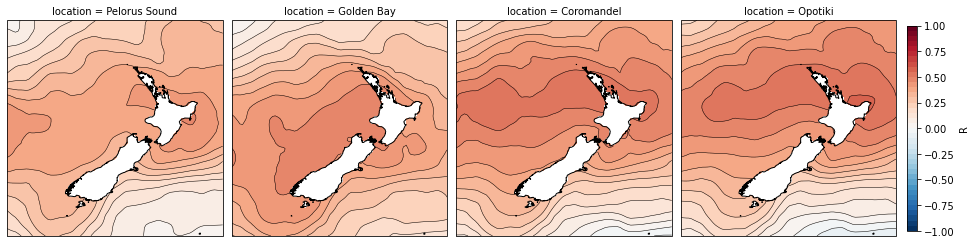

In [82]:
fg = locations_R.plot.contourf(
    levels=np.arange(-1, 1.01, 0.05),
    col="location",
    subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
    transform=ccrs.PlateCarree(),
    figsize=(15, 6),
    cbar_kwargs={"shrink": 0.5, "pad": 0.01, "label": "R"},
)

cs = fg.map_dataarray(
    xr.plot.contour,
    "lon",
    "lat",
    **dict(transform=ccrs.PlateCarree(), add_colorbar=False, inline=True),
    levels=np.arange(-1, 1.01, 0.05),
    colors="k",
    linewidths=0.5,
)

for ax in fg.axs.flat:
    ax.coastlines(resolution="10m")
    # ax.clabel(cs)


fg.fig.savefig(
    fig_path.joinpath(f"R_point_locations_timeseries_MME_hindcasts_step_{step}.png"),
    **fig_kwargs,
)
fg.fig.savefig(
    fig_path.joinpath(f"R_point_locations_timeseries_MME_hindcasts_step_{step}.pdf"),
    **fig_kwargs,
)

In [83]:
point_locations

,lat,lon,extracted_lon,extracted_lat
Pelorus Sound,-41.1628,173.8632,174.125,-41.375
Golden Bay,-40.6548,172.8210,172.875,-40.625
Coromandel,-36.7587,175.4981,175.375,-36.875
Opotiki,-38.0123,177.2871,177.375,-37.875


In [84]:
monthly_time_series_point_locations_df = monthly_time_series_point_locations.to_pandas()

In [85]:
monthly_time_series_point_locations_df

,Pelorus Sound,Golden Bay,Coromandel,Opotiki
time,,,,
1993-01-01,-0.822745,-0.501390,-0.516911,-1.255071
1993-02-01,-1.351453,-1.760451,-2.146569,-2.047745
1993-03-01,-0.958763,-0.610301,-1.233660,-1.053288
1993-04-01,-1.412207,-1.155753,-1.395219,-1.443380
1993-05-01,-1.078521,-0.605850,-0.924588,-1.116113
...,...,...,...,...
2016-08-01,-0.011858,-0.311868,-0.315834,-0.042640
2016-09-01,-0.177357,-0.273302,-0.181458,0.071513
2016-10-01,0.044931,0.400431,0.153936,0.279869


### calculate and plot the auto-correlation function for the monthly time-series of SST observations for the point locations 

In [110]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

In [87]:
point_locations

,lat,lon,extracted_lon,extracted_lat
Pelorus Sound,-41.1628,173.8632,174.125,-41.375
Golden Bay,-40.6548,172.8210,172.875,-40.625
Coromandel,-36.7587,175.4981,175.375,-36.875
Opotiki,-38.0123,177.2871,177.375,-37.875


In [172]:
acfs = {}
acfs_conf = {}

for location in point_locations.index:
    acorr, aconfs = acf(
        monthly_time_series_point_locations_df[location], nlags=24, alpha=0.05
    )

    acfs[location] = acorr
    acfs_conf[location] = aconfs

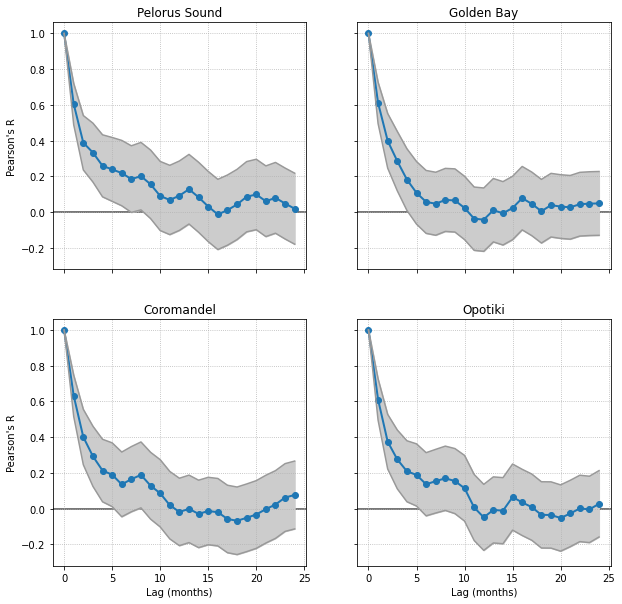

In [198]:
f, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), sharex=True, sharey=True)

axes = axes.flat

for i, location in enumerate(point_locations.index):
    ax = axes[i]

    ax.plot(np.arange(25), acfs[location], lw=2, marker="o")
    ax.plot(np.arange(25), acfs_conf[location][:, 0], color="0.6")
    ax.plot(np.arange(25), acfs_conf[location][:, 1], color="0.6")
    ax.fill_between(
        np.arange(25),
        acfs_conf[location][:, 0],
        acfs_conf[location][:, 1],
        interpolate=True,
        color="0.8",
    )

    ax.axhline(0, color="k", zorder=0, alpha=0.7)

    ax.set_title(location)

    ax.grid(ls=":")

    if i in [0, 2]:
        ax.set_ylabel("Pearson's R")

    if i in [2, 3]:
        ax.set_xlabel("Lag (months)")

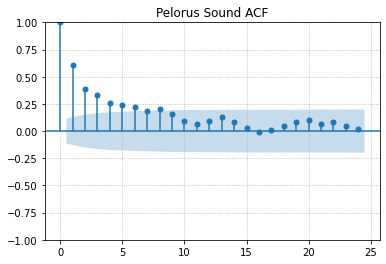

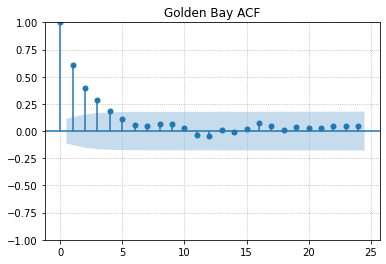

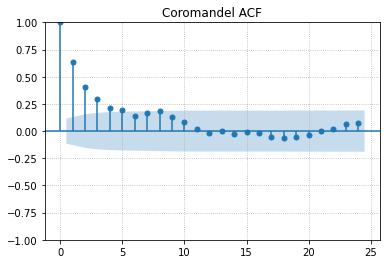

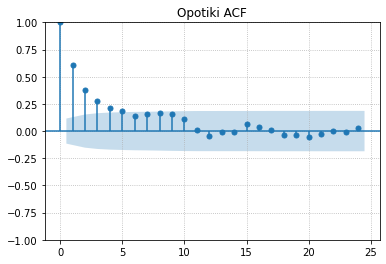

In [174]:
for location in point_locations.index:
    f = plot_acf(monthly_time_series_point_locations_df[location], lags=24, zero=True)
    ax = f.axes[0]
    ax.set_title(f"{location} ACF")
    ax.grid(ls=":")
    f.savefig(
        fig_path.joinpath(f"Autocorrelation_Function_{location.replace(' ','_')}.png"),
        **fig_kwargs,
    )
    f.savefig(
        fig_path.joinpath(f"Autocorrelation_Function_{location.replace(' ','_')}.pdf"),
        **fig_kwargs,
    )

### Get the hindcast ensemble and the observations datasets for climpred, as saved in the notebook `verification_deterministic_sst.ipynb` 

In [89]:
hindcast_ensemble = xr.open_dataset(
    f"../outputs/hindcast/{period}/climpred_hindcasts_initialised_ds.nc"
)

In [90]:
hindcast_observations = xr.open_dataset(
    f"../outputs/hindcast/{period}/climpred_hindcasts_observations_{use_verif}_ds.nc"
)

In [91]:
locations_R_step = []

for step in MME.step.data:
    MMEs = MME.sel(step=step)

    MMEs = MMEs.shift(time=step)

    MMEs = MMEs.dropna(dim="time")

    t, t = xr.align(MMEs.time, monthly_time_series_point_locations.time)

    locations_R = []
    for v in monthly_time_series_point_locations.data_vars.keys():
        R = xr.corr(
            monthly_time_series_point_locations.sel(time=t)[v],
            MMEs.sel(time=t)["sst"],
            dim="time",
        )

        P = xs.pearson_r_p_value

        R = R.expand_dims({"location": [v]})

        locations_R.append(R)

    locations_R = xr.concat(locations_R, dim="location")

    locations_R.expand_dims({"step": [step]})

    locations_R_step.append(locations_R)

In [92]:
locations_R_step = []
locations_P_step = []

for step in MME.step.data:
    MMEs = MME.sel(step=step)

    MMEs = MMEs.shift(time=step)

    MMEs = MMEs.dropna(dim="time")

    t, t = xr.align(MMEs.time, monthly_time_series_point_locations.time)

    locations_R = []
    locations_P = []
    for v in monthly_time_series_point_locations.data_vars.keys():
        R = xs.pearson_r(
            monthly_time_series_point_locations.sel(time=t)[v],
            MMEs.sel(time=t)["sst"],
            dim="time",
            skipna=True,
        )

        P = xs.pearson_r_p_value(
            monthly_time_series_point_locations.sel(time=t)[v],
            MMEs.sel(time=t)["sst"],
            dim="time",
            skipna=True,
        )

        R = R.expand_dims({"location": [v]})

        P = P.expand_dims({"location": [v]})

        locations_R.append(R)

        locations_P.append(P)

    locations_R = xr.concat(locations_R, dim="location")

    locations_P = xr.concat(locations_P, dim="location")

    locations_R.expand_dims({"step": [step]})

    locations_R_step.append(locations_R)

    locations_P.expand_dims({"step": [step]})

    locations_P_step.append(locations_P)

In [93]:
locations_R_step = xr.concat(locations_R_step, dim="step")

In [94]:
locations_R_step = locations_R_step * mask_obs

In [95]:
locations_P_step = xr.concat(locations_P_step, dim="step")

In [96]:
locations_P_step = locations_P_step * mask_obs

In [97]:
ess = locations_R_step.where(locations_P_step <= 0.01)

In [687]:
point_locations

,lat,lon,extracted_lon,extracted_lat
Pelorus Sound,-41.1628,173.8632,174.125,-41.375
Golden Bay,-40.6548,172.8210,172.875,-40.625
Coromandel,-36.7587,175.4981,175.375,-36.875
Opotiki,-38.0123,177.2871,177.375,-37.875


In [691]:
from matplotlib.transforms import offset_copy

In [704]:
cbar_kwargs = {'pad':0.01, 'label':"Pearson's R"}

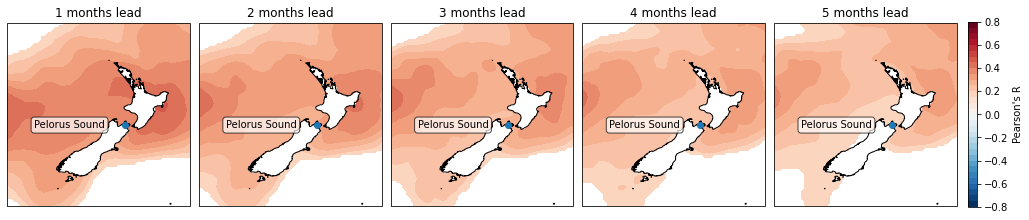

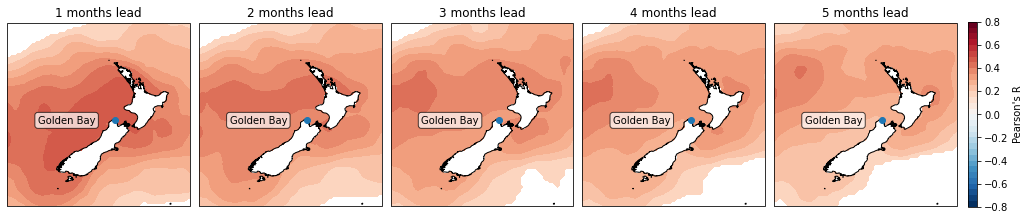

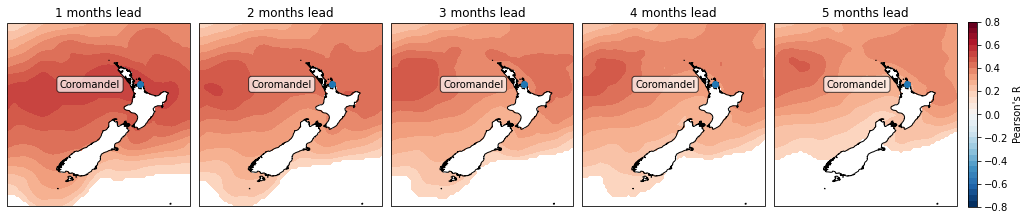

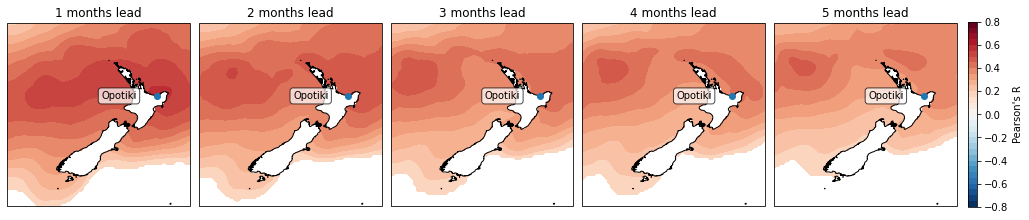

In [706]:
for i, location in enumerate(point_locations.index):
    
    # print(location)

    fg = ess.sel(location=location).plot.contourf(
        levels=np.arange(-0.8, 0.85, 0.05),
        col="step",
        cmap="RdBu_r",
        transform=ccrs.PlateCarree(),
        subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)},
        cbar_kwargs = cbar_kwargs
    )

    axes = fg.axs.flat

    for j, ax in enumerate(axes):
        
        platecarree_transform = ccrs.PlateCarree()._as_mpl_transform(ax)
        text_transform = offset_copy(platecarree_transform, units='dots', x=-20)
        
        ax.coastlines(resolution="10m")
        
        ax.set_title(f"{location}, lead {j+1}")
        
        ax.set_title(f"{j+1} months lead")
        
        ax.plot(point_locations.loc[location,'lon'], point_locations.loc[location,'lat'], transform=ccrs.PlateCarree(), marker='o')
        
        ax.text(point_locations.loc[location,'lon'], point_locations.loc[location,'lat'], location,
            verticalalignment='center', horizontalalignment='right',
            transform=text_transform,
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        
        
    fg.fig.savefig(fig_path.joinpath(f"correlation_map_leadtime_point_location_MME_{location.replace(' ','_')}.png"), **fig_kwargs)
    fg.fig.savefig(fig_path.joinpath(f"correlation_map_leadtime_point_location_MME_{location.replace(' ','_')}.pdf"), **fig_kwargs)

In [108]:
point_locations

,lat,lon,extracted_lon,extracted_lat
Pelorus Sound,-41.1628,173.8632,174.125,-41.375
Golden Bay,-40.6548,172.8210,172.875,-40.625
Coromandel,-36.7587,175.4981,175.375,-36.875
Opotiki,-38.0123,177.2871,177.375,-37.875


In [101]:
corr_by_steps = []

for location in point_locations.index:
    coords = point_locations.loc[location, ["extracted_lon", "extracted_lat"]]

    corr_by_steps.append(
        locations_R_step.sel(
            location=location, lon=coords.extracted_lon, lat=coords.extracted_lat
        )
    )

In [102]:
corr_by_steps = xr.concat(corr_by_steps, dim="location")

In [103]:
corr_by_steps = corr_by_steps.to_pandas().T

In [104]:
corr_by_steps

location,Pelorus Sound,Golden Bay,Coromandel,Opotiki
step,,,,
1,0.372730,0.462424,0.529083,0.557874
2,0.301375,0.389353,0.423617,0.499386
3,0.275281,0.341455,0.358349,0.430276
4,0.247752,0.306032,0.322708,0.403781
5,0.194456,0.251367,0.277276,0.369267


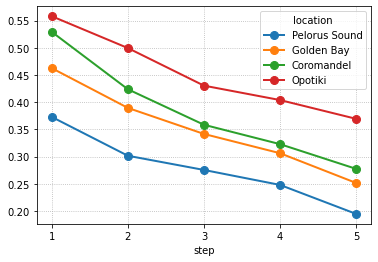

In [106]:
f, ax = plt.subplots()

corr_by_steps.plot(ax=ax, marker="o", lw=2, markersize=8)

ax.set_xticks(corr_by_steps.index)

ax.grid(ls=":")

In [184]:
location = "Opotiki"

In [188]:
start_acorr_lag = 2

In [ ]:
for i, location in enumerate(point_locations.index):
    ax = axes[i]

    ax.plot(np.arange(25), acfs[location], lw=2, marker="o")
    ax.plot(np.arange(25), acfs_conf[location][:, 0], color="0.6")
    ax.plot(np.arange(25), acfs_conf[location][:, 1], color="0.6")
    ax.fill_between(
        np.arange(25),
        acfs_conf[location][:, 0],
        acfs_conf[location][:, 1],
        interpolate=True,
        color="0.8",
    )

    ax.axhline(0, color="k", zorder=0, alpha=0.7)

    ax.set_title(location)

    ax.grid(ls=":")

    if i in [0, 2]:
        ax.set_ylabel("Pearson's R")

    if i in [2, 3]:
        ax.set_xlabel("Lag (months)")

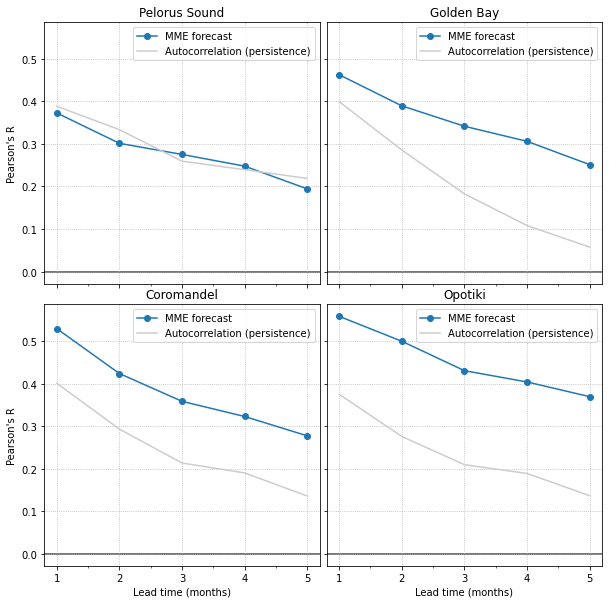

In [686]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharex=True, sharey=True)

f.subplots_adjust(wspace=0.025, hspace=0.08)

axes = axes.flat

for i, location in enumerate(point_locations.index):
    ax = axes[i]

    corr_by_steps.loc[:, location].plot(ax=ax, marker="o", label="MME forecast")

    ax.plot(
        corr_by_steps.index,
        acfs[location][start_acorr_lag : start_acorr_lag + 5],
        color="0.8",
        label="Autocorrelation (persistence)",
    )

    ax.set_xticks(corr_by_steps.index)

    ax.axhline(0, color="k", zorder=0, alpha=0.7)

    ax.set_title(location)

    ax.grid(ls=":")

    if i in [0, 2]:
        ax.set_ylabel("Pearson's R")

    if i in [2, 3]:
        ax.set_xlabel("Lead time (months)")

    else:
        ax.set_xlabel("")

    ax.legend()
    
f.savefig(fig_path.joinpath(f"MME_forecasts_vs_persistence_R_point_locations.png"), **fig_kwargs) 
f.savefig(fig_path.joinpath(f"MME_forecasts_vs_persistence_R_point_locations.pdf"), **fig_kwargs)   

In [213]:
monthly_time_series_point_locations

<xarray.Dataset>
Dimensions:        (time: 288)
Coordinates:
  * time           (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
Data variables:
    Pelorus Sound  (time) float64 -0.8227 -1.351 -0.9588 ... 0.6228 -0.02046
    Golden Bay     (time) float64 -0.5014 -1.76 -0.6103 ... -0.2656 -0.639
    Coromandel     (time) float64 -0.5169 -2.147 -1.234 ... -0.1102 -0.118
    Opotiki        (time) float64 -1.255 -2.048 -1.053 ... -0.1365 -0.3913

In [609]:
point_locations.index

Index(['Pelorus Sound', 'Golden Bay', 'Coromandel', 'Opotiki'], dtype='object')

In [660]:
location = 'Opotiki'

In [661]:
coords = point_locations.loc[location, ["extracted_lon", "extracted_lat"]]

In [662]:
MME_ts = MME.sel(lon=coords.extracted_lon, lat=coords.extracted_lat, method="nearest")

In [663]:
Rs = []

for step in np.arange(5) + 1:
    Rm = []

    for m in np.arange(12) + 1:
        obs_ts_m = monthly_time_series_point_locations.sel(
            time=monthly_time_series_point_locations.time.dt.month == m
        )[location]

        MME_ts_m = MME_ts.sel(step=step)

        MME_ts_m = MME_ts_m.shift(time=step)

        MME_ts_m = MME_ts_m.sel(time=(MME_ts_m.time.dt.month == m))

        t, t = xr.align(obs_ts_m.time, MME_ts_m.time)

        R = xs.pearson_r(obs_ts_m.sel(time=t), MME_ts_m.sel(time=t), skipna=True)[
            varname
        ]

        R = R.expand_dims({"target month": [m]})

        Rm.append(R)

    Rm = xr.concat(Rm, dim="target month")

    Rm = Rm.expand_dims({"step": [step]})

    Rs.append(Rm)

In [664]:
Rs = xr.concat(Rs, dim="step")

In [665]:
Rs_df = Rs.to_pandas()

In [666]:
import seaborn as sns

In [667]:
Rs_df.loc[Rs_df.index[::-1], :]

target month,1,2,3,4,5,6,7,8,9,10,11,12
step,,,,,,,,,,,,
5,0.318060,-0.141255,-0.000019,-0.059703,0.292458,0.483762,0.622141,0.508169,0.693165,0.661286,0.538088,0.534329
4,0.390206,-0.139030,-0.021870,0.075364,0.298682,0.622102,0.587477,0.477838,0.685133,0.675212,0.583637,0.563905
3,0.269541,-0.088006,0.035558,0.089048,0.507251,0.600180,0.618599,0.558525,0.692952,0.742286,0.604621,0.563415
2,0.200908,0.208219,-0.024198,0.468458,0.630792,0.690510,0.704058,0.609654,0.754198,0.721405,0.646463,0.561831
1,0.393951,0.152955,0.327492,0.713261,0.703165,0.708513,0.791196,0.685610,0.736749,0.736925,0.655491,0.462000


<AxesSubplot:xlabel='target month', ylabel='step'>

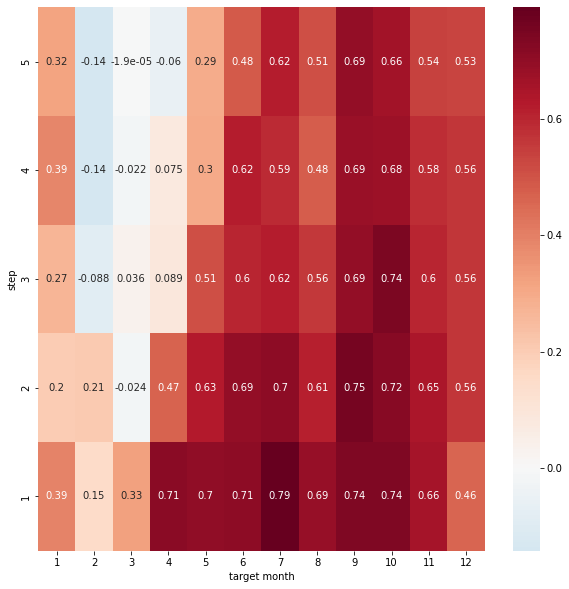

In [668]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(Rs_df.loc[Rs_df.index[::-1], :], annot=True, center=0, cmap="RdBu_r")

In [669]:
obs_location = monthly_time_series_point_locations_df.loc[:, [location]]

In [670]:
obs_acorr_m = obs_location.loc[obs_location.index.month == 7, :]

In [671]:
obs_acorr_m.index.shift(-1, freq="MS")

DatetimeIndex(['1993-06-01', '1994-06-01', '1995-06-01', '1996-06-01',
               '1997-06-01', '1998-06-01', '1999-06-01', '2000-06-01',
               '2001-06-01', '2002-06-01', '2003-06-01', '2004-06-01',
               '2005-06-01', '2006-06-01', '2007-06-01', '2008-06-01',
               '2009-06-01', '2010-06-01', '2011-06-01', '2012-06-01',
               '2013-06-01', '2014-06-01', '2015-06-01', '2016-06-01'],
              dtype='datetime64[ns]', name='time', freq=None)

In [672]:
Rs_maps = xr.open_dataset("../outputs/persistence/Rs_maps_persistence_lag_month.nc")

In [673]:
Rs_location = Rs_maps.sel(
    lon=coords.extracted_lon, lat=coords.extracted_lat, method="nearest"
)

In [674]:
Rs_persistence_df = Rs_location[varname].to_pandas()

In [675]:
Rs_persistence_df.index -= 1

In [676]:
Rs_persistence_df.index.name = "step"

In [677]:
Rs_persistence_df.columns.name = "target month"

In [678]:
Rs_df = Rs_df.sort_index(ascending=False)

In [679]:
Rs_persistence_df = Rs_persistence_df.sort_index(ascending=False)

In [680]:
diff_with_persistence = Rs_df - Rs_persistence_df

In [681]:
mask = diff_with_persistence < 0

In [682]:
mask

target month,1,2,3,4,5,6,7,8,9,10,11,12
step,,,,,,,,,,,,
5,False,False,False,False,True,False,False,False,False,False,False,False
4,False,True,False,True,False,False,False,False,False,False,False,False
3,False,True,True,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False


In [683]:
from calendar import month_abbr

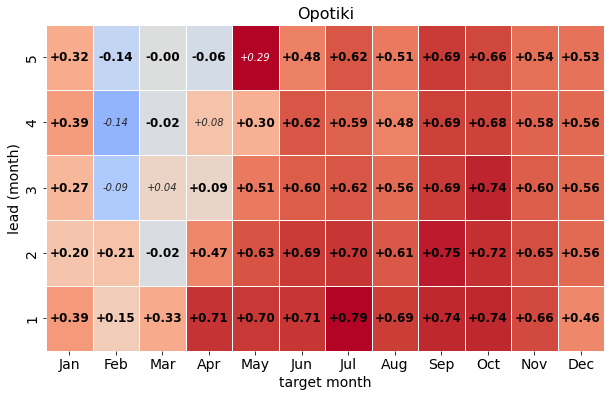

In [684]:
f, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(
    Rs_df,
    ax=ax,
    mask=~mask,
    annot_kws={"style": "italic",  "size":10},
    linewidth=0.5,
    annot=True,
    cmap="coolwarm",
    fmt="+.2f",
    center=0, 
    cbar=False
)

sns.heatmap(
    Rs_df,
    ax=ax,
    mask=mask,
    annot_kws={"weight": "bold", "size":12, "color":'k'},
    linewidth=0.5,
    annot=True,
    cbar=False,
    cmap="coolwarm",
    fmt="+.2f",
    center=0
)

ax.set_ylabel('lead (month)', fontsize=14)

ax.set_xticks(np.arange(12) + 1 - 0.5); 
ax.set_xticklabels(month_abbr[1:], fontsize=14); 

ax.set_yticks(np.arange(5) + 1 - 0.5); 
ax.set_yticklabels(list(map(str, np.arange(5) + 1))[::-1], fontsize=14); 

ax.set_xlabel('target month', fontsize=14)

ax.set_title(location, fontsize=16)

f.savefig(fig_path.joinpath(f"heatmap_R_MME_pointlocation_per_month_{location.replace(' ','_')}.png"), **fig_kwargs)
f.savefig(fig_path.joinpath(f"heatmap_R_MME_pointlocation_per_month_{location.replace(' ','_')}.pdf"), **fig_kwargs)